# Trabalho 1 - Análise exploratória dos dados do Spotify

Autores:
*   Luiza Lober de Souza Piva, nUSP: 9302292
*   Lucas Honorato, nUSP: 13700905

Este trabalho e os resultados salvos das seções 5 e 6 também se encontram na página https://github.com/luizalober/doc-disciplinas/tree/main/estatistica-2s2022/trabalho-1

### Configurações

Rode essas linhas antes de executar o notebook.

In [ ]:
#Rode isto só uma vez
#---> Configurar dependências para importar o .xlsx
!pip install openpyxl
!pip install urllib3 --upgrade 
!pip install requests --upgrade 
!pip install spotipy --upgrade
!pip install plotly

In [ ]:
#Ler e manipular dataframes e valores
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn import preprocessing

#Importar os dados xlsx
import requests as rq
from io import BytesIO

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.io as pio
pio.renderers.default = "colab"   #para plotar os gráficos da px

#Ignora alguns avisos
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

#Para extrair informações da API do Spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [ ]:
#Importando os dados
url = 'https://github.com/luizalober/doc-disciplinas/blob/main/estatistica-2s2022/trabalho-1/Music_DB.xlsx?raw=true'
data = rq.get(url).content
df = pd.read_excel(BytesIO(data))

## Descrição das categorias utilizadas pela API

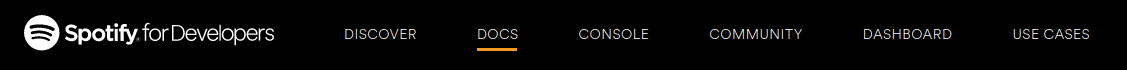

Antes de começar a análise exploratória, é importante entender o que cada categoria representa para as músicas inclusas no conjunto de dados.

Podemos assumir que cada uma das *features* descritas no conjunto `Music_DB.xlsx` corresponde às descritas na [documentação da API do Spotify](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features), onde algumas do nosso conjunto de dados tem nomes traduzidos para o português.

Podemos utilizar a API com uma música do conjunto para realmente garantir a comparação entre as categorias. Vamos utilizar a primeira do `DataFrame` gerado abaixo:

In [ ]:
print('Música escolhida:', df.loc[0].at["Music_name"])
print('---')
df.loc[0]

Música escolhida: The Diary of Jane - Single Version
---


Energia                                       0.964
Ao_vivo                                       0.106
Tempo                                       167.024
Falado                                       0.0644
Orgânico                                   0.000071
Instrumental                                 0.0387
Compasso                                          4
Dançabilidade                                 0.392
Tom                                              10
Duração                                      200547
Força                                      0.599722
Positividade                                  0.269
Modo                                              0
Tipo                                 audio_features
Music_id                     0faXHILILebCGnJBPU6KJJ
Playlist_name                                 Angry
Album_name                   Phobia (Clean Version)
Artista                           Breaking Benjamin
Music_name       The Diary of Jane - Single Version
Name: 0, dty

Ao usar o [Console do Spotify](https://developer.spotify.com/console/get-audio-features-track/) (precisa de autenticação de uma conta) para obter as features do id `0faXHILILebCGnJBPU6KJJ`, obtemos o seguinte,

In [ ]:
'''
{
  "danceability": 0.392,
  "energy": 0.964,
  "key": 10,
  "loudness": -4.441,
  "mode": 0,
  "speechiness": 0.0644,
  "acousticness": 0.0000713,
  "instrumentalness": 0.0387,
  "liveness": 0.106,
  "valence": 0.269,
  "tempo": 167.024,
  "type": "audio_features",
  "id": "0faXHILILebCGnJBPU6KJJ",
  "uri": "spotify:track:0faXHILILebCGnJBPU6KJJ",
  "track_href": "https://api.spotify.com/v1/tracks/0faXHILILebCGnJBPU6KJJ",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/0faXHILILebCGnJBPU6KJJ",
  "duration_ms": 200547,
  "time_signature": 4
}
'''

Com mais uma música:

In [ ]:
print('Música escolhida:', df.loc[42].at["Music_name"])
print('---')
df.loc[42]

Música escolhida: Someone Who Cares
---


Energia                           0.883
Ao_vivo                           0.092
Tempo                            98.147
Falado                           0.0364
Orgânico                         0.0032
Instrumental                        0.0
Compasso                              4
Dançabilidade                     0.468
Tom                                   8
Duração                          292013
Força                          0.645357
Positividade                      0.119
Modo                                  1
Tipo                     audio_features
Music_id         3THZtwFfwGqnJPLdtkbesl
Playlist_name                     Angry
Album_name              Life Starts Now
Artista                Three Days Grace
Music_name            Someone Who Cares
Name: 42, dtype: object

In [ ]:
'''
{
  "danceability": 0.468,
  "energy": 0.883,
  "key": 8,
  "loudness": -3.804,
  "mode": 1,
  "speechiness": 0.0364,
  "acousticness": 0.0032,
  "instrumentalness": 0,
  "liveness": 0.092,
  "valence": 0.119,
  "tempo": 98.147,
  "type": "audio_features",
  "id": "3THZtwFfwGqnJPLdtkbesl",
  "uri": "spotify:track:3THZtwFfwGqnJPLdtkbesl",
  "track_href": "https://api.spotify.com/v1/tracks/3THZtwFfwGqnJPLdtkbesl",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/3THZtwFfwGqnJPLdtkbesl",
  "duration_ms": 292013,
  "time_signature": 4
}
'''

Dessa forma, comparando os valores e utilizando a [API como referência](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features), podemos traçar as seguintes correspondências entre  `variaveis_dos_dados` e as *Variáveis da API*, além de descrevê-las:

*   `Energia` - *energy*: 
  * A energia é uma medida que vai de 0 a 1 e representa a percepção de intensidade e atividade. 
  * Normalmente, músicas energéticas parecem rápidas, altas e barulhentas. Por exemplo, *death metal* têm alta energia, enquanto os prelúdios de Bach têm valores baixos dessa variável. As características de percepção que contribuem para essa nota incluem alcance dinâmico, volume percebido, timbre, valor dado na hora e entropia geral

*   `Ao_vivo` - *liveness*: 
  * Detecta a presença de audiência na gravação; 
  * Valores mais altos indicam uma chance mais alta de que a música tenha sido performada ao vivo, com valores acima de `0.8` indicando uma forte correlação que a faixa é ao vivo. 

*   `Tempo` - *tempo*:
  * O valor médio de uma dada faixa em batidas por minuto (BPM);
  * Em termos musicais, tempo é a velocidade ou o passo de uma dada peça e deriva diretamente da duração de uma batida.

*   `Falado` - *speechness*:
  * Essa variável detecta a presença de palavras faladas na gravação. Quanto mais próximo de falas puras (como em audiobooks, podcasts, poesia), mais perto de `1.0` será o resultado;
  * Valores acima de `0.66` descrevem faixas que provavelmente são compostas totalmente por palavras faladas.
  * Entre `0.33` e `0.66`, as faixas podem conter tanto música instrumental quanto palavras faladas
  * Valores abaixo de `0.33` tem chances maiores de descrever músicas puramente instrumentais.

*   `Orgânico` - *acousticness*: 
  * Uma medida de confiança, de 0 a 1, medindo se a música é acústica ou não. `1.0` representa uma alta confiabilidade de que a música é acustica;

*   `Instrumental` - *instrumentalness*:
  * Prevê se a faixa contém ou não vocais
  * Para a análise do software, sons como *"Ooh"* e *"Aah"* são tratados como instrumentais.
  * Quanto mais perto de `1.0`, maiores as chances de não haver vocais na faixa, com valores acima de `0.5` tendo um indicativo não-nulo dessa característica. 

*   `Compasso` - *time_signature*
  * Um valor *estimado* de compasso. Os valores vão de `3` a `7` e indicam compassos, respectivamente, como "3/4" e "7/4"

*   `Dançabilidade` - *danceability*: 
  * Dançabilidade mede quão interessante a música é para ser dançada, baseado numa combinação de elementos musicais que incluem tempo, estabilidade de ritmo, força da batida e regularidade geral. 
  * Os valores vão de 0 a 1, com `0` representando baixas chances da música ser dançável e `1` altas chances.

*   `Tom` - *key*
  * Essa variável mapeia o tom da faixa, correspondente à [Notação de tom](https://en.wikipedia.org/wiki/Pitch_class)
  * `0 = C`, `1 = C#/Db`, `2 = D`, etc.
  * Se o valor é `-1`, o tom não foi descoberto

*   `Duração` - *duration_ms*: dada em milisegundos (ms)

*   `Força` - **Não há correspondente nos dados!**

*   `Positividade` - *valence*: 
  * Uma medida que vai de `0` a `1` descrevendo a positividade musical que é passada pela faixa. 
  * Músicas que tem maiores valores de positividade são categorizadas como, por exemplo, *happy, cheerful, euphoric*.

*   `Modo` - *mode*
  * Valor que indica a modalidade (maior ou menor) de uma faixa e de que escala o conteúdo melódico é derivado;
  * `1.0` = maior, `0.0` = menor;

*   `Tipo` - *type*
  * O tipo de objeto gerado na busca da faixa. 

*   `Music_id` - *id*
  * O ID do Spotify para a faixa
  
*   `Playlist_name` - **Não há correspondente nos dados!**
*   `Album_name` - **Não há correspondente nos dados!**
*   `Artista` - **Não há correspondente nos dados!**
*   `Music_name` - **Não há correspondente nos dados!**

**Outros comentários importantes**

[Segundo a descrição da análise de músicas da API](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis), algumas das categorias, como `tempo`, `tom`, `compasso` e `loudness` podem ser estimadas por algorítmos internos.

### Hipóteses e planejamento das análises

Vamos agora fazer algumas hipóteses sobre cada uma das variáveis. Isto vai ajudar a guiar as análises subsequentes:



*  Seção 1 - Tirar informações gerais sobre as categorias e checar valores nulos;
   *  Além disto, todas as entradas de `Tipo` são idênticas, contendo somente a descrição do objeto gerado pela classe que analisa os dados na API. Podemos ignorá-la durante a análise.

*   Seção 2 - Correlações que precisam ser checadas, de acordo com as descrições:
    * energia-força;
    * energia-positividade;
    * ao vivo-falado;
    * ao vivo-orgânico;
    * falado-instrumental;
    * dançabilidade-força;
    * dançabilidade-energia;
    * dançabilidade-compasso (mais rápido = mais dança?);
    * dançabilidade-modo.

*   Seção 3 - Algumas variáveis possuem graus de confiabilidade, sendo elas `acoustic`, `instrumental`, `ao vivo`, `falado`: 
  * Um gráfico mostrando a distribuição destes valores seria uma descrição interessante do tipo de música inclusa neste conjunto de dados.

* Seção 4 -  Um gráfico de barras contendo a média de algumas variáveis por playlist pode ser usado para indicar tendências das escolhas de músicas por playlist;
  * Curiosidade: [estes valores foram utilizados para criar um sistema de recomendação automatizado na plataforma Kaggle](https://www.kaggle.com/code/randbwill/spotify-recommendation-system).


*   Seção 5 - As variáveis que não tem correspondência com as da API podem ser entendidas da seguinte forma:
  * `Força`: possível anotação da empresa CLAVE ou de uma versão anterior da API. Pode também ter alguma correlação com `loudness`, o que será checado nesta análise;
  * Outras: possivelmente são informações retiradas da variável `analysis_url`, que contém toda a análise do app sobre tais músicas. Podem ter sido anotadas manualmente através dessas informações.


*   Seção 6 - Podemos usar a API para completar os dados faltantes das faixas. Isto geraria um conjunto de dados que permitiria outras classificações a partir de, por exemplo, número de vezes que um dado artista aparece, nomes comuns de faixa para uma dada playlist, etc.


## Seção 1 - Primeira análise com os dados

In [ ]:
#Visão geral dos dados
df

,Energia,Ao_vivo,Tempo,Falado,Orgânico,Instrumental,Compasso,Dançabilidade,Tom,Duração,Força,Positividade,Modo,Tipo,Music_id,Playlist_name,Album_name,Artista,Music_name
0,0.964,0.1060,167.024,0.0644,0.000071,0.038700,4,0.392,10,200547,0.599722,0.269,0,audio_features,0faXHILILebCGnJBPU6KJJ,Angry,Phobia (Clean Version),Breaking Benjamin,The Diary of Jane - Single Version
1,0.955,0.3800,107.984,0.0653,0.000165,0.000014,4,0.533,8,216733,0.652529,0.550,1,audio_features,2yXyz4NLTZx9CLdXfLTp5E,Angry,Dear Agony,Breaking Benjamin,I Will Not Bow
2,0.939,0.6230,150.184,0.1130,0.000220,0.000000,4,0.524,9,184867,0.631393,0.661,1,audio_features,1Vej0qeQ3ioKwpI6FUbRv1,Angry,Hybrid Theory (Bonus Edition),Linkin Park,Papercut
3,0.969,0.0787,95.136,0.0491,0.001400,0.000001,4,0.492,9,157333,0.601243,0.538,1,audio_features,3K4HG9evC7dg3N0R9cYqk4,Angry,Hybrid Theory (Bonus Edition),Linkin Park,One Step Closer
4,0.970,0.0994,94.952,0.2120,0.030000,0.000000,4,0.512,8,200240,0.639293,0.427,0,audio_features,5egqKwgK5r5rvGD1LrtR7J,Angry,Hybrid Theory (Bonus Edition),Linkin Park,Points of Authority
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7697,0.920,0.0562,100.007,0.0369,0.002120,0.000008,4,0.544,4,272013,0.448745,0.683,0,audio_features,0tJipFCATY8M2WWXXNyJ9p,Nervous,Unholy Savior,Battle Beast,Touch In The Night
7698,0.941,0.0852,124.977,0.0337,0.000026,0.000025,4,0.525,9,177347,0.665350,0.541,0,audio_features,1VKTwfRivDO6neMF6mm9QZ,Nervous,Battle Beast,Battle Beast,Out on the Streets
7699,0.933,0.1740,82.807,0.0774,0.000904,0.000008,4,0.445,4,279587,0.542875,0.517,0,audio_features,3bGMBNy2fhhKYF1haK6pYg,Nervous,Bringer of Pain,Battle Beast,Beyond the Burning Skies
7700,0.886,0.1120,110.021,0.0353,0.000091,0.000431,4,0.506,2,328787,0.630376,0.200,0,audio_features,6NTEk76W6mraayMZV5zhhR,Nervous,Battle Beast,Battle Beast,Into the Heart of Danger


In [ ]:
#Vamos mudar os nomes das colunas para facilitar o acesso
#---> colocando tudo em minúsculas
df.columns= df.columns.str.lower()

#---> mudando acentuações 
df=df.rename(columns = {'orgânico':'organico'})
df=df.rename(columns = {'dançabilidade':'dancabilidade'})
df=df.rename(columns = {'duração':'duracao'})
df=df.rename(columns = {'força':'forca'})

print(df.head(5))

   energia  ao_vivo    tempo  falado  organico  instrumental  compasso  \
0    0.964   0.1060  167.024  0.0644  0.000071      0.038700         4   
1    0.955   0.3800  107.984  0.0653  0.000165      0.000014         4   
2    0.939   0.6230  150.184  0.1130  0.000220      0.000000         4   
3    0.969   0.0787   95.136  0.0491  0.001400      0.000001         4   
4    0.970   0.0994   94.952  0.2120  0.030000      0.000000         4   

   dancabilidade  tom  duracao     forca  positividade  modo            tipo  \
0          0.392   10   200547  0.599722         0.269     0  audio_features   
1          0.533    8   216733  0.652529         0.550     1  audio_features   
2          0.524    9   184867  0.631393         0.661     1  audio_features   
3          0.492    9   157333  0.601243         0.538     1  audio_features   
4          0.512    8   200240  0.639293         0.427     0  audio_features   

                 music_id playlist_name                     album_name  \


In [ ]:
#Contando o número de ocorrências de `tipo = audio_features`
print('Entradas iguais em `Tipo`', df['tipo'].value_counts())
print('Número total de músicas: ', sum(df.index.value_counts()))
print('---')

#Realmente são todas iguais. Vamos remover essa coluna:
df.drop(['tipo'], axis=1, inplace=True)
print(df.head(5))

Entradas iguais em `Tipo` audio_features    7702
Name: tipo, dtype: int64
Número total de músicas:  7702
---
   energia  ao_vivo    tempo  falado  organico  instrumental  compasso  \
0    0.964   0.1060  167.024  0.0644  0.000071      0.038700         4   
1    0.955   0.3800  107.984  0.0653  0.000165      0.000014         4   
2    0.939   0.6230  150.184  0.1130  0.000220      0.000000         4   
3    0.969   0.0787   95.136  0.0491  0.001400      0.000001         4   
4    0.970   0.0994   94.952  0.2120  0.030000      0.000000         4   

   dancabilidade  tom  duracao     forca  positividade  modo  \
0          0.392   10   200547  0.599722         0.269     0   
1          0.533    8   216733  0.652529         0.550     1   
2          0.524    9   184867  0.631393         0.661     1   
3          0.492    9   157333  0.601243         0.538     1   
4          0.512    8   200240  0.639293         0.427     0   

                 music_id playlist_name                     a

### Estatísticas gerais das categorias

In [ ]:
estatisticas = df.describe()
print(estatisticas)

           energia      ao_vivo        tempo       falado     organico  \
count  7702.000000  7702.000000  7702.000000  7702.000000  7702.000000   
mean      0.461560     0.159612   113.737695     0.066433     0.486352   
std       0.335351     0.135808    31.989253     0.063606     0.412783   
min       0.000081     0.022400     0.000000     0.000000     0.000000   
25%       0.113000     0.094300    88.666000     0.036900     0.037000   
50%       0.474000     0.110000   114.061500     0.045200     0.458500   
75%       0.770000     0.157000   133.418250     0.066600     0.944000   
max       1.000000     0.988000   236.136000     0.896000     0.996000   

       instrumental     compasso  dancabilidade          tom       duracao  \
count   7702.000000  7702.000000    7702.000000  7702.000000  7.702000e+03   
mean       0.398859     3.847962       0.494276     5.020774  2.121874e+05   
std        0.429689     0.568963       0.214944     3.567784  7.361206e+04   
min        0.000000  

O código exclui automaticamente as variáveis categóricas desses cálculos.
*   São elas: `music_id`, `playlist_name`, `album_name`, `artista`, `music_name`

Vamos checar quantas entradas possuem entradas não nulas nas variáveis acima.

In [ ]:
print('Total de valores nulos para `music_id`:', sum(pd.isna(df['music_id'])))
print('Percentual nulo:', (sum(pd.isna(df['music_id']))/7702)*100, '%' )
print('---')

print('Total de valores nulos para `playlist_name`:', sum(pd.isna(df['playlist_name'])))
print('Percentual nulo:', (sum(pd.isna(df['playlist_name']))/7702)*100, '%' )
print('---')

print('Total de valores nulos para `album_name`:', sum(pd.isna(df['album_name'])))
print('Percentual nulo:', (sum(pd.isna(df['album_name']))/7702)*100, '%' )
print('---')

print('Total de valores nulos para `artista`:', sum(pd.isna(df['artista'])))
print('Percentual nulo:', (sum(pd.isna(df['artista']))/7702)*100, '%' )
print('---')

print('Total de valores nulos para `music_name`:', sum(pd.isna(df['music_name'])))
print('Percentual nulo:', (sum(pd.isna(df['music_name']))/7702)*100, '%' )
print('---')

Total de valores nulos para `music_id`: 0
Percentual nulo: 0.0 %
---
Total de valores nulos para `playlist_name`: 0
Percentual nulo: 0.0 %
---
Total de valores nulos para `album_name`: 2028
Percentual nulo: 26.330823162814852 %
---
Total de valores nulos para `artista`: 2028
Percentual nulo: 26.330823162814852 %
---
Total de valores nulos para `music_name`: 2028
Percentual nulo: 26.330823162814852 %
---


Disto, usar `album_name`, `artista` ou `music_name` pode ser problemático para fazer categorizações. Este problema é contornado na última seção.

In [ ]:
#Guardando as informações numéricas separadamente (para correlações)
df_num = df

In [ ]:
df_num = df_num.drop(['music_id', 'playlist_name', 'album_name', 'artista', 'music_name'], axis=1)

In [ ]:
df_num

,energia,ao_vivo,tempo,falado,organico,instrumental,compasso,dancabilidade,tom,duracao,forca,positividade,modo
0,0.964,0.1060,167.024,0.0644,0.000071,0.038700,4,0.392,10,200547,0.599722,0.269,0
1,0.955,0.3800,107.984,0.0653,0.000165,0.000014,4,0.533,8,216733,0.652529,0.550,1
2,0.939,0.6230,150.184,0.1130,0.000220,0.000000,4,0.524,9,184867,0.631393,0.661,1
3,0.969,0.0787,95.136,0.0491,0.001400,0.000001,4,0.492,9,157333,0.601243,0.538,1
4,0.970,0.0994,94.952,0.2120,0.030000,0.000000,4,0.512,8,200240,0.639293,0.427,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7697,0.920,0.0562,100.007,0.0369,0.002120,0.000008,4,0.544,4,272013,0.448745,0.683,0
7698,0.941,0.0852,124.977,0.0337,0.000026,0.000025,4,0.525,9,177347,0.665350,0.541,0
7699,0.933,0.1740,82.807,0.0774,0.000904,0.000008,4,0.445,4,279587,0.542875,0.517,0
7700,0.886,0.1120,110.021,0.0353,0.000091,0.000431,4,0.506,2,328787,0.630376,0.200,0


## Seção 2 - Correlações

<AxesSubplot:>

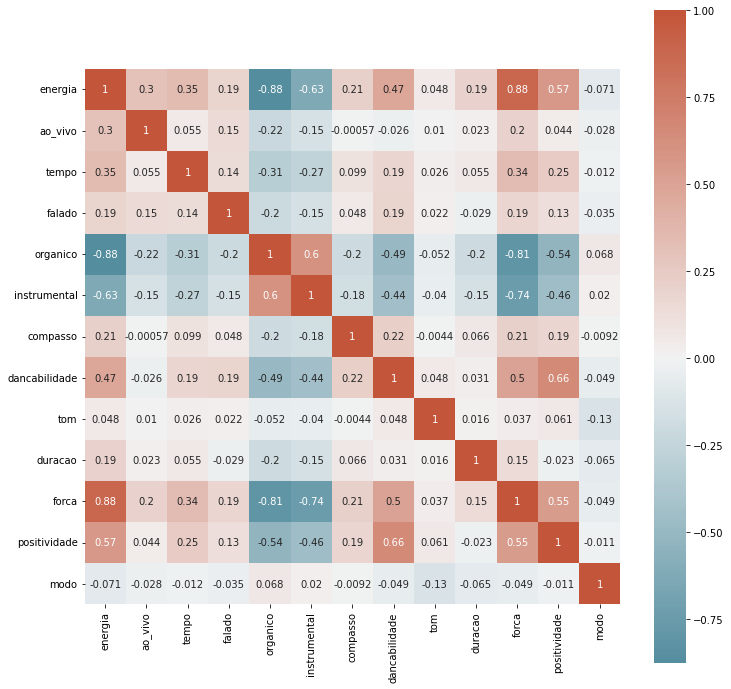

In [ ]:
#Abaixo, grafica as correlações entre todas as variáveis numéricas dos dados
plt.figure(figsize=(12,12))
corr_columns = df_num.columns[list(df_num.corr().apply( lambda value: value >0 ).sum()>1)]
corr=df_num.corr().loc[corr_columns, corr_columns]
div_red_blue = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr,square=True,center=0,annot=True, cmap=div_red_blue)

#ref: https://www.kaggle.com/general/210058
#paleta de cores: https://seaborn.pydata.org/tutorial/color_palettes.html

<AxesSubplot:>

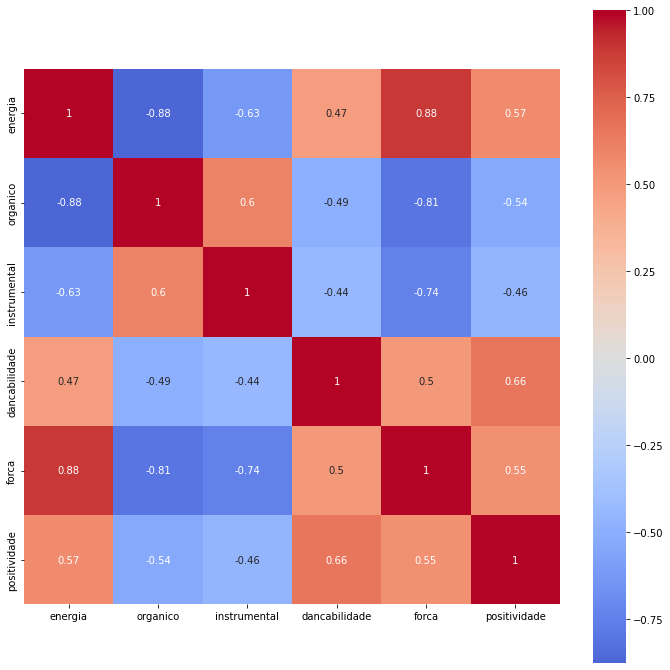

In [ ]:
#Agora, grafica considerando somente correlações altas
plt.figure(figsize=(12,12))
#Salva somente correlações maiores que 0.5 ou menores que -0.5
high_corr_columns = df_num.columns[list(df_num.corr().apply( lambda value: value > 0.5 ).sum()>1)]
corr=df_num.corr().loc[high_corr_columns, high_corr_columns]

div_spectral = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr,square=True,center=0,annot=True, cmap=div_spectral)

Podemos ver que há correlações fortes entre algumas variáveis:
*   Decrescentes: `orgânico` e `energia` (-0.88), `orgânico` e `força` (-0.81), `instrumental` e `força` (-0.74)
*   Crescente: `força` e `energia` (0.88), `dançabilidade` e `positividade` (0.66), `instrumental` e `orgânico` (0.6)

Vamos explorar essas variáveis em maiores detalhes abaixo: 

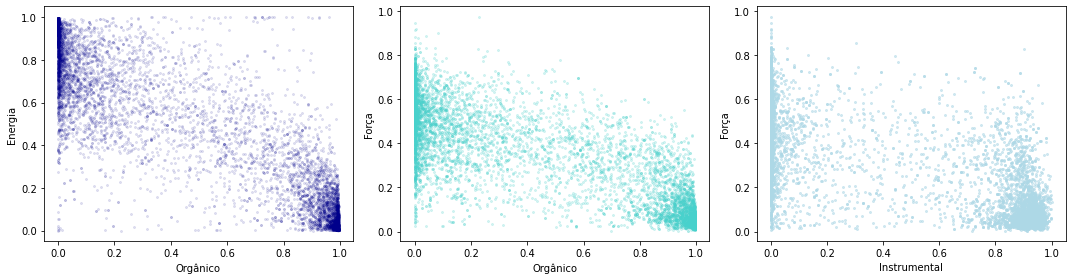

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))

#organico vs energia
axs[0].plot('organico', 'energia', "", data=df_num, color='darkblue', linestyle='', marker='o', markersize=2, alpha=0.1)
axs[0].set_xlabel('Orgânico')
axs[0].set_ylabel('Energia')

#organico vs força
axs[1].plot('organico', 'forca', "", data=df_num, color='mediumturquoise', linestyle='', marker='o', markersize=2, alpha=0.2)
axs[1].set_xlabel('Orgânico')
axs[1].set_ylabel('Força')

#instrumental vs força
axs[2].plot('instrumental', 'forca', "", data=df_num, color='lightblue', linestyle='', marker='o', markersize=2, alpha=0.5)
axs[2].set_xlabel('Instrumental')
axs[2].set_ylabel('Força')

#finaliza
fig.tight_layout()

Como esperado no caso de correlações negativas, os padrões acima mostram um espalhamento dos dados para lados opostos dos gráficos, detalhando o comportamento inversamente proporcional entre as variáveis.

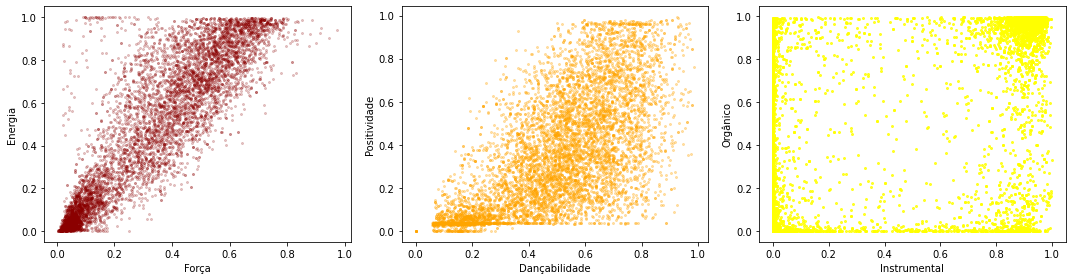

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))

#organico vs energia
axs[0].plot('forca', 'energia', "", data=df_num, color='darkred', linestyle='', marker='o', markersize=2, alpha=0.2)
axs[0].set_xlabel('Força')
axs[0].set_ylabel('Energia')

#organico vs força
axs[1].plot('dancabilidade', 'positividade', "", data=df_num, color='orange', linestyle='', marker='o', markersize=2, alpha=0.3)
axs[1].set_xlabel('Dançabilidade')
axs[1].set_ylabel('Positividade')

#instrumental vs força
axs[2].plot('instrumental', 'organico', "", data=df_num, color='yellow', linestyle='', marker='o', markersize=2, alpha=0.8)
axs[2].set_xlabel('Instrumental')
axs[2].set_ylabel('Orgânico')

#finaliza
fig.tight_layout()

Nas correlações positivas, vemos que `força` e `energia` possuem uma distribuição quase linear devido a alta correlação entre as mesmas, com o padrão mostrado nas outras duas figuras detalhando correlações mais fracas.

## Seção 3 - Categorias com intervalos de confiança

Podemos utilizar alguns plots do tipo *violin* para entender as variáveis que possuem intervalos de confiança para uma dada categoria (`ao_vivo`, `falado`, `organico`, `instrumental`, `dancabilidade`, `positividade`). O gráfico abaixo também contém um boxplot em cinza associado à cada variável.

[Template adaptado de 'Palmer Penguins exploration with violinplots in Matplotlib'](https://www.python-graph-gallery.com/web-ggbetweenstats-with-matplotlib)

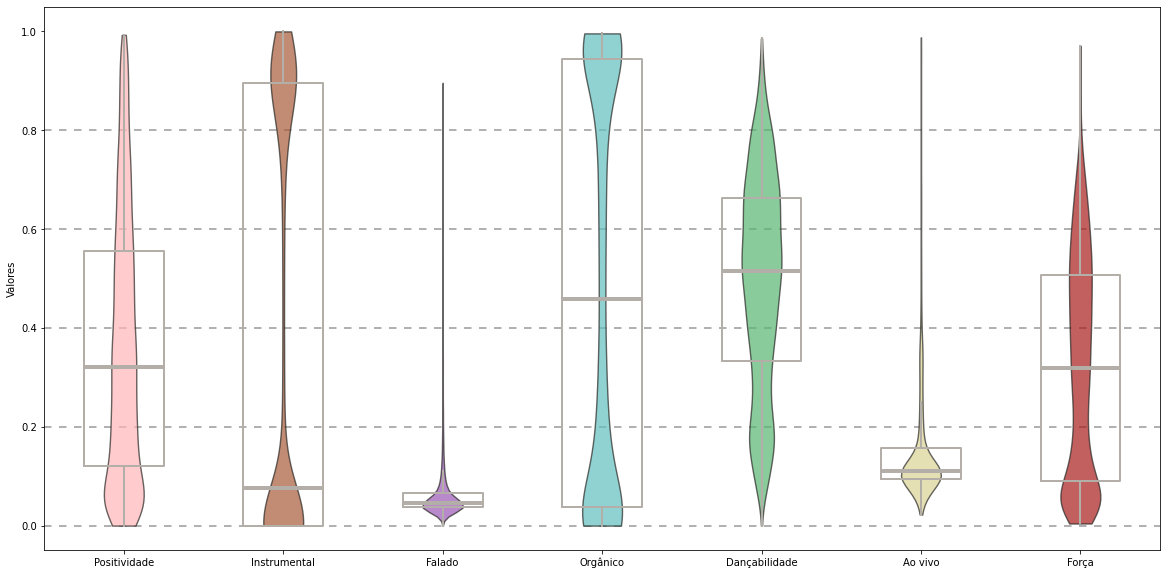

In [ ]:
#Importa os dados que serão graficados
y_data = df.filter(items=['positividade', 'instrumental', 'falado', 'organico', 'dancabilidade', 'ao_vivo', 'forca'])

# Cores para as linhas
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Cores para os violinos (de https://htmlcolorcodes.com/)
COLOR_SCALE = ["#FFB6B9", "#A85A38", "#9B59B6", "#61C0BF", "#59b672", "#DBD394", "#A81C1C"]

# Posições horizontais para os violinos. Números arbitrários
POSITIONS = [0, 1, 2, 3, 4, 5, 6]

# Posição das linhas horizontais
HLINES = [0, 0.2, 0.4, 0.6, 0.8]

#Cria a figura
fig, ax = plt.subplots(figsize= (20, 10))

# Linhas horizontais que são utilizadas como referências
for h in HLINES:
    ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Cria os violinos ----------------------------------------------------

# A saída é guardada em 'violins', que é utilizada para customizar a aparência dos mesmos
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.25,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False,
)

# Faz a customização
color = 0
for pc in violins["bodies"]:
    a = COLOR_SCALE[color]
    pc.set_facecolor(a)
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(0.7)
    color = color +1

# Cria os boxplots ---------------------------------------------------
# As propriedades do box são passadas como dicionários

medianprops = dict(
    linewidth=4, 
    color=GREY_LIGHT,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_LIGHT
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Não mostra os outliers
    showcaps = False,   
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['Positividade', 'Instrumental', 'Falado', 'Orgânico', 'Dançabilidade', 'Ao vivo', 'Força'])
ax.set_ylabel('Valores')

fig.show()

Portanto, neste conjunto de dados,

*  As músicas não tem uma `positividade` tão alta. Segundo a próxima figura (gráfico de barras), a maior concentração delas está na playlist "Annoying", e de fato a média dos valores entre todas as playlists é bem similar;

*  `instrumental` e `orgânico` estão distribuidos de maneira parecida, o que pode indicar uma distinção bem definida dos dados segundo essas características;

*  A maior concentração de `falado` e `Ao vivo` está abaixo de 0.33, o que indica que as músicas do conjunto de dados possivelmente foram gravadas em estúdio;
  * Lembrando que poderiam haver podcasts e programas de voz nos dados, o que resultaria em valores observados mais altos em `falado` aqui.

*  As músicas deste conjunto tem uma alta `dançabilidade`, mas isto não é tão marcante quanto as distribuições de `falado` e `ao vivo`.

## Seção 4 - Média das variáveis por playlist

O gráfico de barras apresentado nessa seção, em conjunto com as conclusões do gráfico acima, visa caracterizar cada uma das playlists que foram inclusas no conjunto de dados.

In [ ]:
#Temos as seguintes playlists:
playlists = df.playlist_name.unique()
print(playlists)

['Angry' 'Annoying' 'Boring' 'Calm' 'Excited' 'Happy' 'Nervous' 'Peaceful'
 'Pleased' 'Relaxed' 'Sad' 'Sleepy']


In [ ]:
#O gráfico abaixo é interativo: passe o mouse por este gráfico para ver os valores médios detalhadamente.

fig = px.histogram(df, x='playlist_name', y=['energia', 'positividade', 'instrumental', 'falado', 'forca', 'organico', 'dancabilidade', 'ao_vivo'], barmode='group', histfunc='avg',)
fig.update_layout(
    xaxis_title="Playlists",
    yaxis_title="Contagem por categoria",
    legend_title="Variáveis",
)
fig.show()

As variáveis `tempo`, `compasso` e `tom` não foram inclusas por saírem da escala.

**Conclusões**

Gerais:
*   As variáveis `ao_vivo` e `falado` tem médias próximas para todas as playlists, além da baixa variabilidade dessas variáveis observada nos violinos. Pode-se dizer que elas não são distintivas para as playlists.

Podemos então classificar as playlist por conter:

Obs: Usei os intervalos como **baixo:** $< 0.3$, $0.3 \leq $ **mediano:** $\leq 0.6$ e **alto**: $> 0.6$

*   `Angry`: alta energia, força. Valores medianos de positividade e dançabilidade. Todo o resto com valores baixos; 
  * **Variável mais proeminente**: força (maior média de todas);

*   `Annoying`: alta energia, positividade, e dançabilidade. Valores medianos de força e todo o resto com baixas contagens;
  * **Variável mais proeminente**: força.

*   `Boring`: alta dançabilidade. Valores medianos de energia, positividade, instrumental, e força. Todo o resto com baixas contagens;
  * **Variável mais proeminente**: dançabilidade.

*   `Calm`: alto orgânico, instrumental e dançabilidade. Positividade mediana (quase baixa), com todo o resto com baixas contagens;
  * **Variável mais proeminente**: orgânico.

*   `Excited`: alta energia, dançabilidade, positividade e força. Todo o resto com baixas contagens;
  * **Variável mais proeminente**: energia.

*   `Happy`: alta energia, dançabilidade, positividade e força. Todo o resto com baixas contagens;
  * **Variável mais proeminente**: energia
  * Esta playlist tem uma tendência similar à anterior, com a maior diferença entre as duas se dando nas médias de instrumental. 

*   `Nervous`: alta energia, dançabilidade, positividade e força (este último marginalmente alto). Instrumental mediano e todo o resto com baixas contagens;
  * * **Variável mais proeminente**: dançabilidade.

*   `Peaceful`: alto organico e instrumental.Valores medianos de dançabilidade. Todo o resto com baixas contagens;
  * * **Variável mais proeminente**: orgânico (maior média de todas).

*   `Pleased`: alta força. Valores medianos de dançabilidade, positividade e força. Todo o resto com baixas contagens;
  * * **Variável mais proeminente**: força.

*   `Relaxed`: alto instrumental e orgânico. Valores medianos de dançabildiade e todo o resto com baixas contagens;
  * * **Variável mais proeminente**: orgânico.

*   `Sad`: valores medianos de organico, dançabilidade, energia e força. Todo o resto com baixas contagens;
  * * **Variável mais proeminente**: orgânico.

*   `Sleepy`: Altos valores de instrumental e orgânico e todo o resto com baixas contagens;
  * * **Variável mais proeminente**: instrumental (maior média de todas).

*Comentário da Luiza*: Estas distribuições seguem a intuição que eu tive ao olhar o nome das playlists e entender o que cada variável significava.

## Seção 5 - Força <-> *loudness*?

Vamos verificar aqui se existe uma correlação entre a característica `Força`, do conjunto de dados original, e a `Loudness`, da API. Isto pode ser um bom indicativo para identificarmos a origem dessa característica.

In [ ]:
#Primeiro, vamos pegar os dados de Força:
valores_de_forca = df[['forca']]

#Agora, a ideia é extrair os valores de loudness das mesmas músicas, 
#através da API, e comparar com a distribuição acima.

#Para isto, vou usar uma versão modificada do código da última seção ("Completando o conjunto de dados")
#---> Credenciais (as mesmas da próxima seção)
client_id = "b7dfa4e9dfe341edb55225ed466df828"
client_secret = "664137ab9d1b4c1d9df6ccd4ba3e3341"
scope = "user-library-read"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 


In [ ]:
#Aqui, guarda os ids que queremos usar para extrair loudness
#essa célula é pensada de forma que possa ser rerodada caso ocorram erros,
#sem perder a contagem de onde o algorítmo da última célula parou
#--->(a API é bastante bugada e isto se fez necessário)

ids = []

#comentar se rerodar por erro:
num = 0
valores_de_loud = []

for row in range(num, len(df), 1):
    ids.append(df['music_id'].iloc[row])

In [ ]:
#Aqui, vamos extrair loudness para todas as 7702 faixas do conjunto de dados

for id in ids:
  #Pega informações da análise das faixas
  valores = sp.audio_features(id)   #Usando US aqui porque nem todas estão no Brasil

  #Loudness
  swp = valores[0]
  info_loud = swp.get('loudness')

  #Adiciona no vetor 
  valores_de_loud.append(info_loud)

  print(len(valores_de_loud), 'operações rodadas.')
  num = num+1

In [ ]:
#Essa célula salva os resultados de loudness como um DataFrame de uma única coluna,
#para referência futura
guardando = pd.DataFrame(valores_de_loud)
len(guardando)
guardando.to_excel("Music_DB-Valores_de_loudness.xlsx")

Agora, vamos entender a escala dos valores de loudness.
Como a escala de decibéis é originalmente dada por 

$$ 10 \log_{10} \frac{P}{P_0} $$

e `loudness` é medida de -60 a 0, o que corresponde a razões $ 0 < P/P_0 \leq 1$.


Portanto, o gráfico abaixo fará a comparação entre estes valores com os de `Força` em escala log (gráfico logxlog):

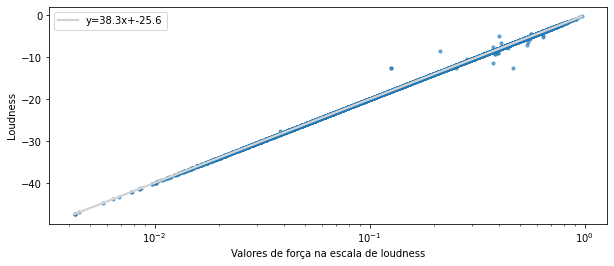

In [ ]:
plt.figure(figsize=(10, 4))

slope, intercept, r_value, p_value, std_err = st.linregress(df['forca'],valores_de_loud)

ax = sns.regplot(x=valores_de_forca, y=valores_de_loud, logx=True, scatter_kws={'alpha':0.6, 's': 10}, line_kws={'color': 'lightgray', 'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.xlabel("Valores de força na escala de loudness")
plt.ylabel("Loudness")
plt.xscale("log")
ax.legend()

plt.show()

Logo, dado o intervalo de confiança padrão do `regplot()` de 95% e excluindo alguns pontos fora da curva, há um forte indício que `Força` realmente seja a variável `Loudness` normalizada para uma escala de 0 a 1.

## Seção 6 - Completando o conjunto de dados

Nesta última seção, queremos utilizar o poder de fogo da API para obter os valores faltantes das variáveis `album_name`, `artista` e `music_name`. Para isto, vamos usar o ID único de cada música do conjunto de dados (`music_id`) que não possui identificação para fazer a extração destas características de interesse.

In [ ]:
#Autenticação: credenciais da Luiza
client_id = "b7dfa4e9dfe341edb55225ed466df828"
client_secret = "664137ab9d1b4c1d9df6ccd4ba3e3341"
scope = "user-library-read"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 

In [ ]:
teste = sp.track('4e3S4W8SmflgP8jwK2ceTZ', market='BR')
teste

Couldn't read cache at: .cache
Couldn't write token to cache at: .cache


{'album': {'album_type': 'single',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/10Z7WzKMeIdNBKexi1YarP'},
    'href': 'https://api.spotify.com/v1/artists/10Z7WzKMeIdNBKexi1YarP',
    'id': '10Z7WzKMeIdNBKexi1YarP',
    'name': 'Fame on Fire',
    'type': 'artist',
    'uri': 'spotify:artist:10Z7WzKMeIdNBKexi1YarP'}],
  'external_urls': {'spotify': 'https://open.spotify.com/album/4NOPILdmrNFPZwcP8dnJ4X'},
  'href': 'https://api.spotify.com/v1/albums/4NOPILdmrNFPZwcP8dnJ4X',
  'id': '4NOPILdmrNFPZwcP8dnJ4X',
  'images': [{'height': 640,
    'url': 'https://i.scdn.co/image/ab67616d0000b27377d7c32da9a8fb70a3bed9a9',
    'width': 640},
   {'height': 300,
    'url': 'https://i.scdn.co/image/ab67616d00001e0277d7c32da9a8fb70a3bed9a9',
    'width': 300},
   {'height': 64,
    'url': 'https://i.scdn.co/image/ab67616d0000485177d7c32da9a8fb70a3bed9a9',
    'width': 64}],
  'name': 'XO TOUR Llif3',
  'release_date': '2017-06-02',
  'release_date_precision': 'day',
  

In [ ]:
#Vamos filtrar pelas informações que queremos:
#-> Nome do artista
artista = teste.get('album').get('artists')
nome_do_artista = artista[0].get('name')
print('Artista:', nome_do_artista)

#-> Nome do álbum
album = teste.get('album').get('name')
print('Album: ', album)

#-> Nome da música
musica = teste.get('name')
print('Música: ', musica)

Artista: Fame on Fire
Album:  XO TOUR Llif3
Música:  XO TOUR Llif3


O próximo passo agora é automatizar isto para as entradas do conjunto de dados.

In [ ]:
#Vamos fazer as operações num novo dataframe para evitar perder dados
df_completo = df.copy()

In [ ]:
#Guarda todos os índices nulos e os IDs correspondentes das músicas
ind_nulos = []
ids = []

for row in df.index:
    if pd.isnull(df['artista'].iloc[row]):
      ids.append(df['music_id'].iloc[row])
      ind_nulos.append(row)

In [ ]:
#Faz as substituições

#Detalhe IMPORTANTÍSSIMO: nem todas as músicas estão disponíveis num mesmo país.
#A forma como contornei isso foi alterar a variável 'market' entre 'BR' e 'US',
#rerodando a célula acima cada vez que eu reiniciava o loop abaixo (o que garante
#que ele vai seguir de onde parou ao dar erro)

#E às vezes a API só buga e interrompe sua request. Tente rodar novamente quando isso acontecer
#assim como na seção anterior, as células foram pensadas de forma que você possa rerodar
#sem perder a contagem ou os dados já extraídos.

#**Extra**: ignore possíveis erros de cache. Isso acontece por esse notebook estar sendo
#rodado no Colab.

colunas_alteradas = []

num = 0
for id in ids:
  #Pega informações
  valores = sp.track(id, market='BR')   #Usando US aqui porque nem todas estão no Brasil

  #Album
  info_musica = valores.get('album').get('artists')
  nome_do_artista = info_musica[0].get('name')
  #-> Nome do álbum
  album = valores.get('album').get('name')
  #-> Nome da música
  musica = valores.get('name')

  #Substitui
  df_completo.at[ind_nulos[num],'artista'] = nome_do_artista
  df_completo.at[ind_nulos[num],'album_name'] = album
  df_completo.at[ind_nulos[num],'music_name'] = musica

  colunas_alteradas.append(num)
  print(len(colunas_alteradas), '+1 operações de ', len(ind_nulos))

  num = num+1

In [ ]:
#Verificando se deu certo:
print('Total de valores nulos para `album_name`:', sum(pd.isna(df_completo['album_name'])))
print('Percentual nulo:', (sum(pd.isna(df_completo['album_name']))/7702)*100, '%' )
print('---')

print('Total de valores nulos para `artista`:', sum(pd.isna(df_completo['artista'])))
print('Percentual nulo:', (sum(pd.isna(df_completo['artista']))/7702)*100, '%' )
print('---')

print('Total de valores nulos para `music_name`:', sum(pd.isna(df_completo['music_name'])))
print('Percentual nulo:', (sum(pd.isna(df_completo['music_name']))/7702)*100, '%' )
print('---')

Total de valores nulos para `album_name`: 0
Percentual nulo: 0.0 %
---
Total de valores nulos para `artista`: 0
Percentual nulo: 0.0 %
---
Total de valores nulos para `music_name`: 0
Percentual nulo: 0.0 %
---


In [ ]:
#Vamos salvar esses resultados!
df_completo.to_excel("Music_DB-Completo.xlsx")